In [9]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [10]:

# Set the paths to your train, test, and validation directories
train_dir = "final_dataset/train"
test_dir = "final_dataset/test"
val_dir = "final_dataset/validation"

# Define the image size and number of classes
image_size = (240, 240)  # Adjust image size based on the requirements
num_classes = 101

# Create data generators with enhanced data augmentation for the train set
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    # Additional preprocessing techniques
    brightness_range=[0.8, 1.2],  # Random brightness adjustment
   
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=32,
    class_mode="categorical"
)

# Create data generators for the test and validation sets (no data augmentation)
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=32,
    class_mode="categorical",
    shuffle=False  # Do not shuffle test data for evaluation
)

val_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=32,
    class_mode="categorical"
)



Found 75750 images belonging to 101 classes.
Found 15150 images belonging to 101 classes.
Found 10100 images belonging to 101 classes.


In [11]:
# Load the pre-trained EfficientNetB7 model (include_top=False to exclude classification layers)
base_model = EfficientNetB1(
    include_top=False,  # Exclude the top (output) layer
    weights='imagenet',  # Load pre-trained weights
    input_shape=(240, 240, 3)  # Specify input shape (adjust based on your requirements)
)

# Fine-tune the model by making some layers trainable
for layer in base_model.layers:
    layer.trainable = False  # You can set specific layers to trainable or not

# Add custom classification layers on top of the pre-trained model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [12]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 240, 240, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 240, 240, 3)  7          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                            

                                                                                                  
 block2a_expand_conv (Conv2D)   (None, 120, 120, 96  1536        ['block1b_add[0][0]']            
                                )                                                                 
                                                                                                  
 block2a_expand_bn (BatchNormal  (None, 120, 120, 96  384        ['block2a_expand_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 block2a_expand_activation (Act  (None, 120, 120, 96  0          ['block2a_expand_bn[0][0]']      
 ivation)                       )                                                                 
                                                                                                  
 block2a_d

 block2c_expand_activation (Act  (None, 60, 60, 144)  0          ['block2c_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block2c_dwconv (DepthwiseConv2  (None, 60, 60, 144)  1296       ['block2c_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block2c_bn (BatchNormalization  (None, 60, 60, 144)  576        ['block2c_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block2c_activation (Activation  (None, 60, 60, 144)  0          ['block2c_bn[0][0]']             
 )        

 )                                                                                                
                                                                                                  
 block3b_activation (Activation  (None, 30, 30, 240)  0          ['block3b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block3b_se_squeeze (GlobalAver  (None, 240)         0           ['block3b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block3b_se_reshape (Reshape)   (None, 1, 1, 240)    0           ['block3b_se_squeeze[0][0]']     
                                                                                                  
 block3b_s

 block4a_activation (Activation  (None, 15, 15, 240)  0          ['block4a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4a_se_squeeze (GlobalAver  (None, 240)         0           ['block4a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4a_se_reshape (Reshape)   (None, 1, 1, 240)    0           ['block4a_se_squeeze[0][0]']     
                                                                                                  
 block4a_se_reduce (Conv2D)     (None, 1, 1, 10)     2410        ['block4a_se_reshape[0][0]']     
                                                                                                  
 block4a_s

 block4c_se_expand (Conv2D)     (None, 1, 1, 480)    10080       ['block4c_se_reduce[0][0]']      
                                                                                                  
 block4c_se_excite (Multiply)   (None, 15, 15, 480)  0           ['block4c_activation[0][0]',     
                                                                  'block4c_se_expand[0][0]']      
                                                                                                  
 block4c_project_conv (Conv2D)  (None, 15, 15, 80)   38400       ['block4c_se_excite[0][0]']      
                                                                                                  
 block4c_project_bn (BatchNorma  (None, 15, 15, 80)  320         ['block4c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4c_d

 block5a_project_conv (Conv2D)  (None, 15, 15, 112)  53760       ['block5a_se_excite[0][0]']      
                                                                                                  
 block5a_project_bn (BatchNorma  (None, 15, 15, 112)  448        ['block5a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5b_expand_conv (Conv2D)   (None, 15, 15, 672)  75264       ['block5a_project_bn[0][0]']     
                                                                                                  
 block5b_expand_bn (BatchNormal  (None, 15, 15, 672)  2688       ['block5b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block5b_e

 block5d_expand_conv (Conv2D)   (None, 15, 15, 672)  75264       ['block5c_add[0][0]']            
                                                                                                  
 block5d_expand_bn (BatchNormal  (None, 15, 15, 672)  2688       ['block5d_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block5d_expand_activation (Act  (None, 15, 15, 672)  0          ['block5d_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block5d_dwconv (DepthwiseConv2  (None, 15, 15, 672)  16800      ['block5d_expand_activation[0][0]
 D)                                                              ']                               
          

                                                                                                  
 block6b_dwconv (DepthwiseConv2  (None, 8, 8, 1152)  28800       ['block6b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block6b_bn (BatchNormalization  (None, 8, 8, 1152)  4608        ['block6b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block6b_activation (Activation  (None, 8, 8, 1152)  0           ['block6b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6b_s

 )                                                                                                
                                                                                                  
 block6d_activation (Activation  (None, 8, 8, 1152)  0           ['block6d_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6d_se_squeeze (GlobalAver  (None, 1152)        0           ['block6d_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6d_se_reshape (Reshape)   (None, 1, 1, 1152)   0           ['block6d_se_squeeze[0][0]']     
                                                                                                  
 block6d_s

 block7a_se_squeeze (GlobalAver  (None, 1152)        0           ['block7a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block7a_se_reshape (Reshape)   (None, 1, 1, 1152)   0           ['block7a_se_squeeze[0][0]']     
                                                                                                  
 block7a_se_reduce (Conv2D)     (None, 1, 1, 48)     55344       ['block7a_se_reshape[0][0]']     
                                                                                                  
 block7a_se_expand (Conv2D)     (None, 1, 1, 1152)   56448       ['block7a_se_reduce[0][0]']      
                                                                                                  
 block7a_se_excite (Multiply)   (None, 8, 8, 1152)   0           ['block7a_activation[0][0]',     
          

In [13]:
# Define Callbacks
checkpoint = ModelCheckpoint("efficientB1.h5", save_best_only=True, monitor='val_loss', mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, mode='max', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, mode='min', verbose=1)

# List of callbacks
callbacks_list = [checkpoint, early_stopping, reduce_lr]


In [14]:
import time
start_time = time.time()

In [15]:
# Train the model
history = model.fit(
    train_generator,  # Your training dataset
    validation_data=val_generator,  # Your validation dataset
    epochs=300,  # Adjust the number of epochs
    callbacks=callbacks_list,
    verbose=1
)

Epoch 1/300
2368/2368 [==============================] - ETA: 0s - loss: 2.6906 - accuracy: 0.3940
Epoch 1: val_loss improved from inf to 1.77534, saving model to efficientB1.h5
2368/2368 [==============================] - 836s 351ms/step - loss: 2.6906 - accuracy: 0.3940 - val_loss: 1.7753 - val_accuracy: 0.5582 - lr: 1.0000e-04
Epoch 2/300
2368/2368 [==============================] - ETA: 0s - loss: 1.7806 - accuracy: 0.5530
Epoch 2: val_loss improved from 1.77534 to 1.51773, saving model to efficientB1.h5
2368/2368 [==============================] - 832s 351ms/step - loss: 1.7806 - accuracy: 0.5530 - val_loss: 1.5177 - val_accuracy: 0.6146 - lr: 1.0000e-04
Epoch 3/300
2368/2368 [==============================] - ETA: 0s - loss: 1.6055 - accuracy: 0.5887
Epoch 3: val_loss improved from 1.51773 to 1.41031, saving model to efficientB1.h5
2368/2368 [==============================] - 829s 350ms/step - loss: 1.6055 - accuracy: 0.5887 - val_loss: 1.4103 - val_accuracy: 0.6345 - lr: 1.0000e

Epoch 26/300
2368/2368 [==============================] - ETA: 0s - loss: 1.0670 - accuracy: 0.7114
Epoch 26: val_loss did not improve from 1.12572
2368/2368 [==============================] - 823s 347ms/step - loss: 1.0670 - accuracy: 0.7114 - val_loss: 1.1268 - val_accuracy: 0.7005 - lr: 1.0000e-04
Epoch 27/300
2368/2368 [==============================] - ETA: 0s - loss: 1.0604 - accuracy: 0.7113
Epoch 27: val_loss improved from 1.12572 to 1.12550, saving model to efficientB1.h5
2368/2368 [==============================] - 826s 349ms/step - loss: 1.0604 - accuracy: 0.7113 - val_loss: 1.1255 - val_accuracy: 0.7008 - lr: 1.0000e-04
Epoch 28/300
2368/2368 [==============================] - ETA: 0s - loss: 1.0532 - accuracy: 0.7140
Epoch 28: val_loss improved from 1.12550 to 1.12194, saving model to efficientB1.h5
2368/2368 [==============================] - 828s 350ms/step - loss: 1.0532 - accuracy: 0.7140 - val_loss: 1.1219 - val_accuracy: 0.7025 - lr: 1.0000e-04
Epoch 29/300
2368/2368

Epoch 52/300
2368/2368 [==============================] - ETA: 0s - loss: 0.9130 - accuracy: 0.7479
Epoch 52: val_loss improved from 1.11028 to 1.11007, saving model to efficientB1.h5
2368/2368 [==============================] - 833s 352ms/step - loss: 0.9130 - accuracy: 0.7479 - val_loss: 1.1101 - val_accuracy: 0.7064 - lr: 1.0000e-06
Epoch 53/300
2368/2368 [==============================] - ETA: 0s - loss: 0.9184 - accuracy: 0.7477
Epoch 53: val_loss improved from 1.11007 to 1.10963, saving model to efficientB1.h5
2368/2368 [==============================] - 824s 348ms/step - loss: 0.9184 - accuracy: 0.7477 - val_loss: 1.1096 - val_accuracy: 0.7067 - lr: 1.0000e-06
Epoch 54/300
2368/2368 [==============================] - ETA: 0s - loss: 0.9130 - accuracy: 0.7487
Epoch 54: val_loss improved from 1.10963 to 1.10958, saving model to efficientB1.h5
2368/2368 [==============================] - 830s 351ms/step - loss: 0.9130 - accuracy: 0.7487 - val_loss: 1.1096 - val_accuracy: 0.7069 - l

In [16]:
end_time = time.time()
training_time = end_time - start_time
print(f"Total training time: {training_time:.2f} seconds")

Total training time: 46351.43 seconds


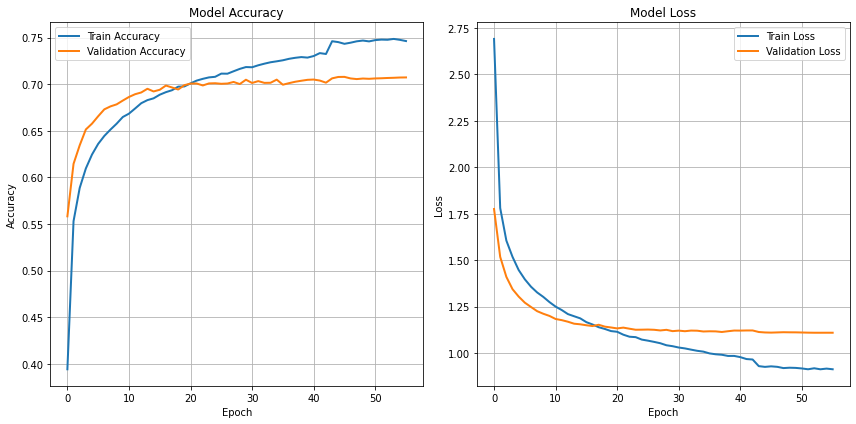

In [17]:
import matplotlib.pyplot as plt


# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [ ]:
# Save the training history to a file
import pickle
with open('training_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)